In [155]:
from math import pi

import pandas as pd
import numpy as np
import os
from bokeh.plotting import figure, show, output_file
import bokeh

#Self Identified Triangle Pattern stocks
#AAPL, JNJ, CAT, NVDA
#------------------------------------------------
#-----------USER INPUT---------------------------
#------------------------------------------------
#Symbol to be called
symbol = 'ETH'  3
line_dist = 5
#The maximum that a line can extend
day_diff = 17

#When matching up the lines, this is the difference in days that the
#lines are able to extend
match_diff_start = 2
match_diff_end = 2
#------------------------------------------------

#Calls the script to get a csv with stock data from x days ago,
#If you want to change the amount of days, have to edit under
#download_quotes() in get-yahoo-quotes
# os.system('python get-yahoo-quotes.py ' + symbol)


#Dataframe used for indices as follows
# np.random.seed(42)
# strd_start=np.random.randint(150,200)
# strd_end = np.random.randint(500,800)

df = pd.read_csv('../ETH-D.csv',index_col=0,parse_dates=True)
# df=btc_data
# df=btc_data.copy()
# df.index=pd.DatetimeIndex(df.index)
df=df.loc['2022-11-05':]
df['Date']=df.index



# df=df.iloc[strd_start:strd_end,:]
#Access the dataframe for reading
#print(df)

inc = df.Close > df.Open
dec = df.Open > df.Close
w = 12*60*60*1000 # half day in ms

TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

p = figure(x_axis_type="datetime", tools=TOOLS, title = symbol+" Candlestick",height=400, width=1300,toolbar_location='below')
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.3
#actual candlestick creator
p.segment(df.Date, df.High, df.Date, df.Low, color="black")


# #Creates the candlesticks, for each bar there
p.vbar(df.Date[inc], w, df.Open[inc], df.Close[inc], fill_color="red", line_color="red")
p.vbar(df.Date[dec], w, df.Open[dec], df.Close[dec], fill_color="green", line_color="green")


#Create an numpy array for highs, lows, and dates from DataFrame
highs = np.array(df['High'])
lows = np.array(df['Low'])
dates = np.array(df['Date'])
days = highs.size

#Print the number of days of the data
print("Days in data:", days)

#Connects all of the highs together and lows together
#p.line(dates, highs)
#p.line(dates, lows)


#----------------Find the Swings-----------------------------
#Stores the day(index) at which a max/min is found
#Will create a dataframe of this later
max_prices = []
max_dates = []
max_days = []
min_prices = []
min_dates = []
min_days = []

#This for loop will find the peak of the highs
#This also signifies a swing pattern throughout the days
for x in range(1, days-2):
    if highs[x-1] < highs[x] > highs[x+1] or x == 1:
        #p.circle(dates[x],highs[x])
        max_prices.append(highs[x])
        max_dates.append(dates[x])
        max_days.append(x)

for y in range(1, days-2):
    if lows[y-1] > lows[y] < lows[y+1]:
        #p.circle(dates[y],lows[y])
        min_prices.append(lows[y])
        min_dates.append(dates[y])
        min_days.append(y)

updated_price=[]
for xx in range(1,max_prices-1):
    if max_prices[x-1] < max_prices[x] > max_prices[x+1] or x == 1:



Days in data: 92


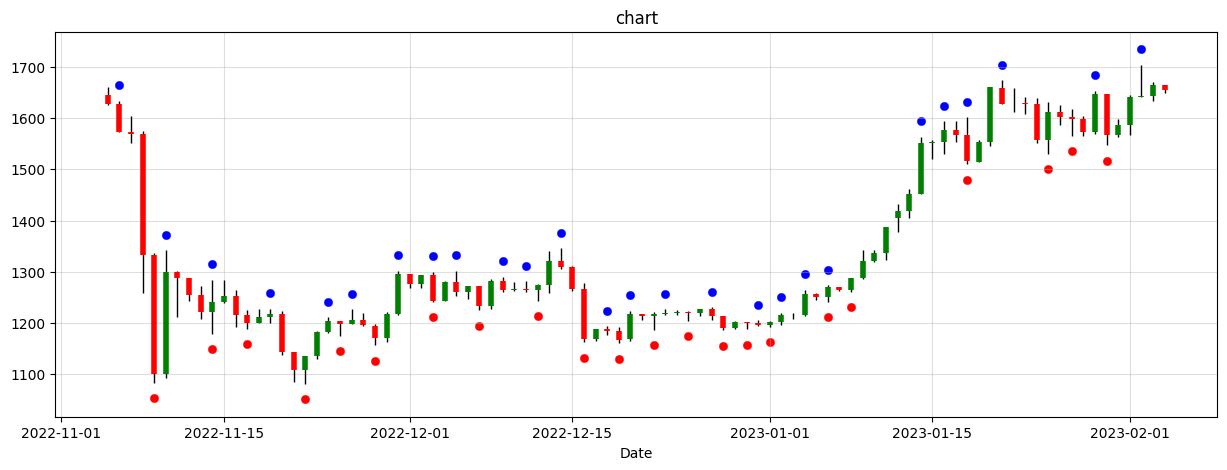

In [156]:
# bokeh.plotting(np.arange(len(max_prices)),max_prices)
import matplotlib.pyplot as plt
inc=df.Close > df.Open
dec=df.Open > df.Close
# plt.scatter(np.arange(len(max_prices)),max_prices)

# plt.axvline(df.Date, ymin=df.Open, ymax=df.Close)
# xposition = [0.3, 0.4, 0.45]

close=np.array(df.Close)
low=np.array(df.Low)
high=np.array(df.High)

import matplotlib.pyplot as plt
import pandas as pd

# Convert df.Date column to datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Define values for xc, low, and close
# plt.Figure(figsize=(20,5))
fig = plt.figure(figsize=(15, 5))
# Plot vertical lines
bar_width=4
# for xc in range(len(df)):

plt.vlines(x=df.Date, ymin=low, ymax=high, color='k', linestyle='-',
                    linewidth=1)
    
# Move the high a little more
max_copy=max_prices.copy()
# max_copy+1
cal_1=(np.zeros(len(max_copy)) + 30 ) + max_copy
cal_2=(np.zeros(len(min_prices)) - 30) + min_prices

plt.vlines(df.Date[inc],df.Open[inc],df.Close[inc],color='green',linewidth=bar_width)
plt.vlines(df.Date[dec],df.Open[dec],df.Close[dec],color='red',linewidth=bar_width)

plt.scatter(max_dates,cal_1 ,linewidths=0.3,color='blue',) 
plt.scatter(min_dates,cal_2,linewidths=0.3,color='red',) 
# Set x-axis label
plt.xlabel('Date')
plt.grid(alpha=0.4)
plt.title('chart')
plt.show()

In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume,Date
Date,,,,,,,
2022-11-05,1645.156494,1660.486450,1625.964233,1627.968018,1627.968018,11006973190,2022-11-05
2022-11-06,1627.901123,1634.132446,1572.234741,1572.234741,1572.234741,11632744705,2022-11-06
2022-11-07,1572.016968,1604.475342,1550.415527,1568.591309,1568.591309,15279963349,2022-11-07
2022-11-08,1568.329590,1574.799805,1259.443115,1332.835571,1332.835571,42048003440,2022-11-08
2022-11-09,1333.122437,1335.743530,1083.285645,1100.169800,1100.169800,38864492427,2022-11-09
...,...,...,...,...,...,...,...
2023-01-31,1567.419922,1598.517578,1563.804321,1586.535400,1586.535400,6585191019,2023-01-31
2023-02-01,1586.488159,1644.727539,1566.857300,1641.792725,1641.792725,8116969489,2023-02-01
2023-02-02,1641.365967,1704.458130,1641.322632,1643.241577,1643.241577,10558081069,2023-02-02


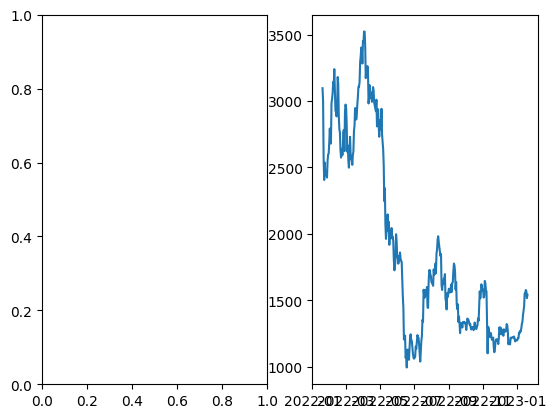

In [7]:


################# ploting in subplot with matplotlib################
fig, axs = plt.subplots()
axs.plot(df.Close)

# # or if we want to add a axis to a figure alone
# fig=plt.figure(figsize=(15,8))
# ax=fig.add_subplot(1,1,1)
##################################################################



#######################################Phase One ################################
# 1. how can we calcualte the ichimuku data to store and then analyize

#2.  How do you wnat to find all the swing in the base_line and anotehr two line from ichimuku

#3.  how can we plot the dash line and  simple line for the symetric trinagel

#4.  you know that we need the live APi for the chart

#5.  optimzer of the shadow in the chart

#6.  what about the Dataset, how can we store our valid Dataset?

#7.  so what if we colelct all the data, what then what do we do after that?

#8.  how can we put everything togheter


##############################################################################

#######################################Phase two #############################

##############################################################################


a:\python_env1\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


a:\python_env1\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


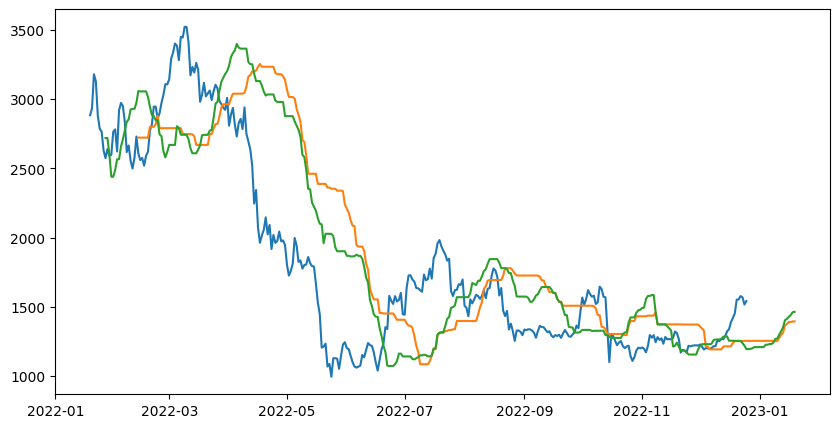

In [1]:
##################### Good starting point########################
import pandas_ta as ta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch

from ichimoku import plt_candle,add_plot, cal_ich


# df=pd.read_csv('./ETH-USD.csv')
df=cal_ich('./ETH-USD.csv')
fig,ax=plt.subplots(1,figsize=(10,5))
# plt_candle('./ETH-USD.csv',ich=True,full=True,ax=ax)
ich_value=df[['chikou_span','kijun_sen','tenkan_sen']]
ax.plot(ich_value)


In [38]:
# finding hte swing in the top:
highs = np.array(df['High'])
lows = np.array(df['Low'])
dates = np.array(df.index)
days = highs.size
tenkan=np.array(ich_value.tenkan_sen)
kijun=np.array(ich_value.kijun_sen)
chikou=np.array(ich_value.chikou_span)
max_prices = []
max_dates = []
max_days = []
min_prices = []
min_dates = []
min_days = []

days=len(ich_value)
#This for loop will find the peak of the highs
#This also signifies a swing pattern throughout the days
def round(turn=None):
    def calculating(chikou=None):
        length=chikou.size
        virtual_prices=[]
        virtual_dates=[]
        virtual_days=[]
        for x in range(1, length-2):
            
            if chikou[x-2] < chikou[x] > chikou[x+2] or x == 1:
        
                virtual_prices.append(chikou[x])
                virtual_dates.append(chikou[x])
                virtual_days.append(x)

            
        max_prices=virtual_prices
        max_dates=virtual_dates
        max_days=virtual_days
        virtual_dates.clear()
        virtual_prices.clear()
        virtual_days.clear()        

        return max_prices,max_dates,max_days

    for i in range(turn):
        if i==0:
            max_prices,max_dates,max_days=calculating(chikou=chikou)             
        else:
            
            max_prices,max_dates,max_days=calculating(chikou=max_prices)

round(turn=2)



AttributeError: 'list' object has no attribute 'size'

In [21]:
max_prices.size

AttributeError: 'list' object has no attribute 'size'

Data is loaded


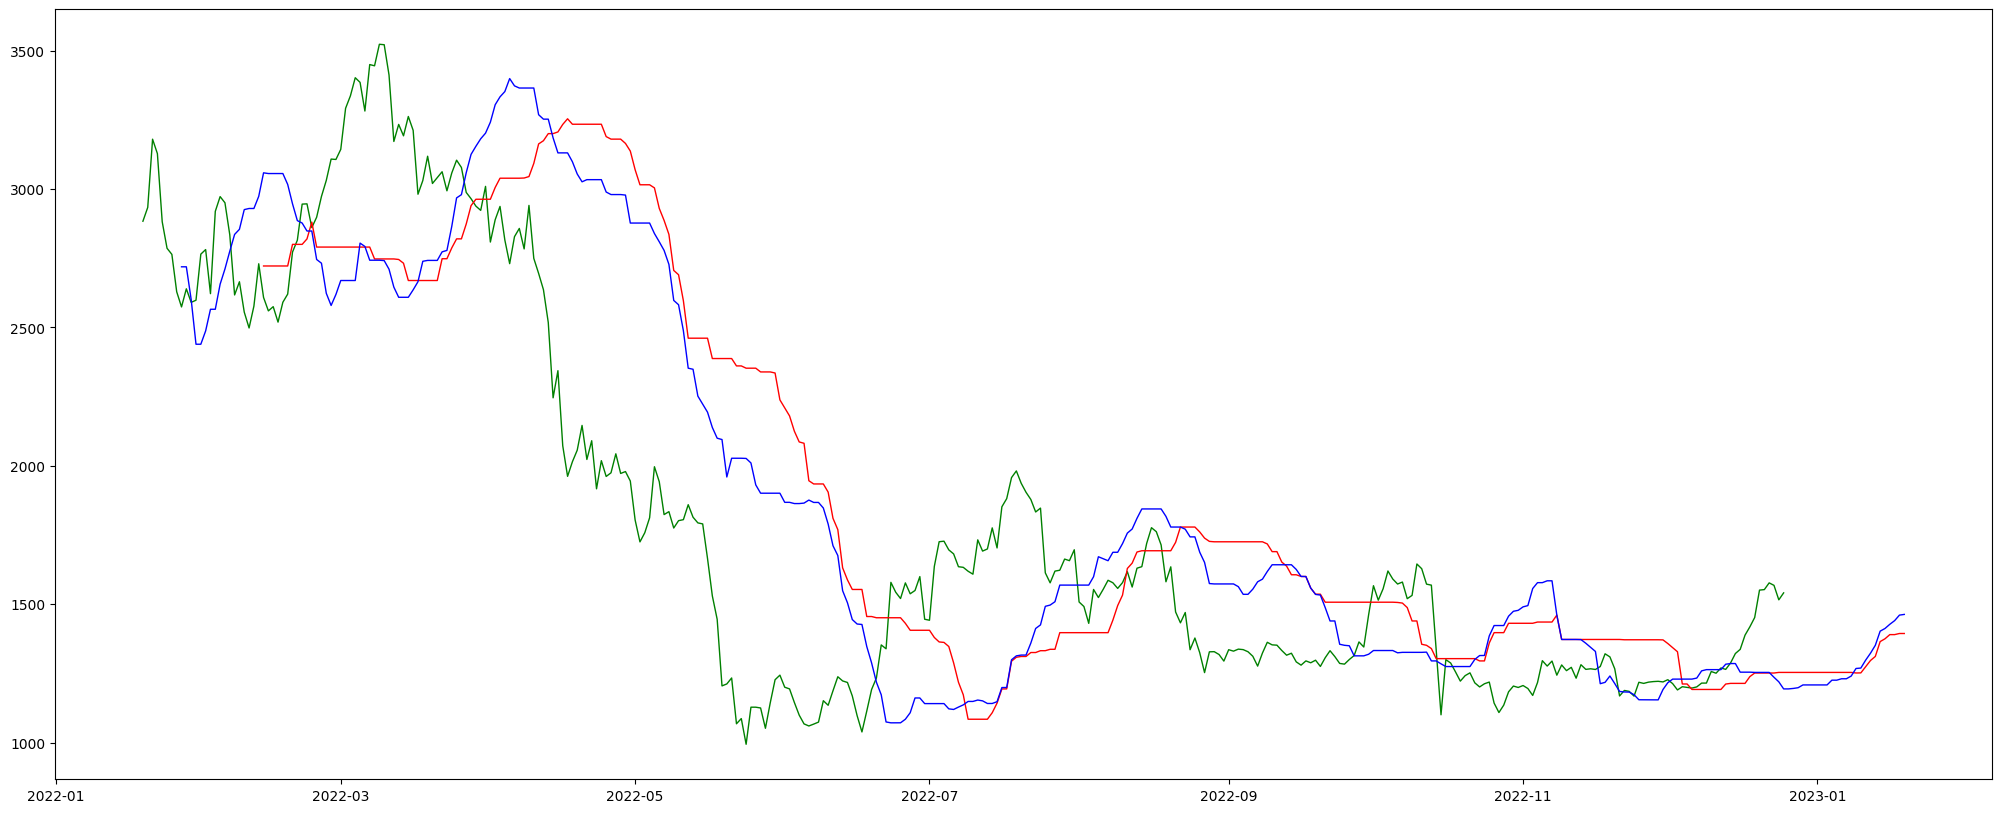

In [9]:
fig,ax=plt.subplots(1,figsize=(25,10))
# ax.scatter(min_dates,min_prices,c='blue')
ax.scatter(max_dates,max_prices,c='red')
plt_candle('./ETH-USD.csv',ax=ax,full=None,ich=True)